#Chapter 5: The Mechanics of Learning
*  Understanding how algorithms can learn from data
*  Reframing learning as parameter estimation, using differentiation and gradient descent
*  Walking through a very simple learning algorithm from scratch
*  How PyTorch supports learning with autograd

In [1]:
#Importing Necessary Libraries
import numpy as np
import torch
%matplotlib inline
torch.set_printoptions(edgeitems=2,linewidth=75)

### **5.1.1 A Hot Problem**
Scenario:

"We just go back from our trip to some obscure location, we brought back a fancy, wall-mounted analog thermometer. It looks great, it is perfect fit for our living room. Its only flaw: it does not show units. Not to worry, we have got a plan: we will build a dataset of readings and corresponding temperature values in our favorite units, choose a model, adjust its weights iteratively until a measure of the error is low enough and we will finally be able to interpret the new readings in units we understand.

In [2]:
#Temperature data in Celsius
t_c=[0.5,14.0,15.0,28.0,11.0,8.0,3.0,-4.0,6.0,13.0,21.0]

#Temperature data in the new thermometer
t_u=[35.7,55.9,58.2,81.9,56.3,48.9,33.9,21.8,48.4,60.4,68.4]

#Convert the data above to tensors
t_c=torch.tensor(t_c)
t_u=torch.tensor(t_u)

### **5.1.2 Choosing a Linear Model as a First Try**
We simply guess the relation between t_c and t_u with this formula:

t_c = w * t_u + b

We will see whether this model is reasonable by perform it in the analysis. Here, 'w' is weight and 'b' is bias. This formula follows **linear scaling**. 

We will estimate the value of 'w' and 'b', or we called **the parameters of the model**. In order to get that, we will train our neural network using the data that we have. To examine whether the model can catch the relation between t_c and t_u, we measure it using what is called **loss function** where the lower value indicates better or perfect match.

### **5.1.3 Less Loss is What We Want**
The calculation of loss typically involves taking the difference between the desired outputs for some training samples (t_p - t_c) and those actually produced by the model (t_p) when fed those samples.

The choices for loss calculation are:
|t_p - t_c| or (t_p - t_c)^2

### **5.1.4 From Problem to PyTorch**
So, let us put it in PyTorch framework.


In [3]:
#First, define the model of t_c = w * t_u + b
def model(t_u,w,b): #That means the function model() needs input: 't_u', 'w', and 'b'
  #print("t_u:",t_u)
  return w*t_u+b

In [4]:
#Second, define the loss function (t_p - t_c)^2
def loss_fn(t_p,t_c): #t_p is the predicted t_c
  squared_diffs=(t_p-t_c)**2
  #print(squared_diffs)
  return squared_diffs.mean() #Mean Square Loss

In [5]:
#Third, initialize the parameters 'w' and 'b'
w=torch.ones(()) #Initially weighted by 1
b=torch.zeros(()) #Initially with no bias

t_p=model(t_u,w,b)
print("t_p:",t_p)
#So, the t_p after calculation in model() still consists of the original value of t_p

t_p: tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])


In [6]:
#Fourth, check the loss value
loss=loss_fn(t_p,t_c)
loss

tensor(1763.8846)

Now that we get the main concept of the calculation, **how do we get the minimum loss so that we can find the best 'w' and 'b' value for our model?**

### **5.1.5 Down Along the Gradient**
The way to **optimize** our parameters is using **gradient descent algorithm**. It computes the rate of change of the loss with respect to each parameter and apply a change to each parameter in the direction of decreasing loss. 

In [7]:
#delta=0.1
#loss_rate_of_change_w=(loss(model(t_u,w+delta,b),t_c)-loss(model(t_u,w-delta,b),t_c))/(2.0*delta)

In [8]:
#learning_rate=1e-2
#w=w-learning_rate*loss_rate_of_change_w

In [9]:
#loss_rate_of_change_b=(loss(model(t_u,w,b+delta),t_c)-loss(model(t_u,w,b-delta),t_c))/(2.0*delta)
#b=b-learning_rate*loss_rate_of_change_b

### **5.1.6 Getting Analytical**
In order to compute the derivative of the loss with respect to a parameter, we can apply the chain rule and compute the derivative of the loss with respect to its input (which is output of the model), times the derivative of the model with respect to the parameter, or in mathematical expressions:

**d loss / d w = (d loss / d t_p) * (d t_p / d w)**

In [10]:
#Fifth, compose the derivative loss() function
def dloss(t_p,t_c):
  dsq_diffs=2*(t_p-t_c)/t_p.size(0) #The division is from the derivative of mean
  #print("Derivative Loss Function: ",dsq_diffs)
  return dsq_diffs

In [11]:
#Sixth, compose the derivatice of model() function with respect to 'w'
def dmodel_dw(t_u,w,b):
  #print(dmodel_dw)
  return t_u

In [12]:
#Seventh, compose the derivatice of model() function with respect to 'b'
def dmodel_db(t_u,w,b):
  #print(dmodel_db)
  return 1.0

In [13]:
#Putting all this together, the function returning the gradient of the loss with respect to 'w' and 'b' is
#This part is Back Propagation using Chain Rule
def grad_fn(t_u,t_c,t_p,w,b):
  dloss_dtp=dloss(t_p,t_c)
  dloss_dw=dloss_dtp*dmodel_dw(t_u,w,b)
  dloss_db=dloss_dtp*dmodel_db(t_u,w,b)
  #print("Derivative Loss/Derivative t_p:",dloss_dtp)
  #print("Derivative Loss/Derivative w:",dloss_dw)
  #print("Derivative Loss/Derivative b:",dloss_db)
  #The summation is the backward we implicitly do when applying the parameters to an entire vector of inputs in model.
  return torch.stack([dloss_dw.sum(),dloss_db.sum()])

### **5.1.7 The Training Loop**
We can now start the optimization part of our model parameters. We can iteratively apply updates to it for a fixed number of iterations, or until 'w' and 'b' stop changing. 

In [14]:
#Training Loop with Fixed Iterations Number
def trainingloop(n_epochs,lr,params,t_u,t_c):
  for epoch in range(1,n_epochs+1):
    w,b=params

    t_p=model(t_u,w,b) #THIS IS FORWARD PASS
    loss=loss_fn(t_p,t_c)
    grad=grad_fn(t_u,t_c,t_p,w,b) #THIS IS BACKWARD PASS USING CHAIN RULE

    params=params-lr*grad

    #print("Params Calculation:",params)
    #print("What is Grad?", grad)
    #print("What about Loss?",loss)

    print('Epoch %d, Loss %f' % (epoch,float(loss))) #THIS IS LOGGING LINE
    print("Params:", params)
    print("Grad:",grad)

  return params

In [15]:
#Invoking Training Loop with Learning Rate (lr) = 1e-2, see what happened
trainingloop(n_epochs=100,
             lr=1e-2,
             params=torch.tensor([1.0,0.0]),
             t_u=t_u,
             t_c=t_c)

Epoch 1, Loss 1763.884644
Params: tensor([-44.1730,  -0.8260])
Grad: tensor([4517.2969,   82.6000])
Epoch 2, Loss 5802485.500000
Params: tensor([2568.4014,   45.1637])
Grad: tensor([-261257.4219,   -4598.9712])
Epoch 3, Loss 19408035840.000000
Params: tensor([-148527.7344,   -2616.3933])
Grad: tensor([15109614.0000,   266155.7188])
Epoch 4, Loss 64915909902336.000000
Params: tensor([8589999.0000,  151310.8594])
Grad: tensor([-8.7385e+08, -1.5393e+07])
Epoch 5, Loss 217130559820791808.000000
Params: tensor([-4.9680e+08, -8.7510e+06])
Grad: tensor([5.0539e+10, 8.9023e+08])
Epoch 6, Loss 726257583152928129024.000000
Params: tensor([2.8732e+10, 5.0610e+08])
Grad: tensor([-2.9229e+12, -5.1486e+10])
Epoch 7, Loss 2429183992928415200051200.000000
Params: tensor([-1.6617e+12, -2.9270e+10])
Grad: tensor([1.6904e+14, 2.9776e+12])
Epoch 8, Loss 8125126681682403942989824000.000000
Params: tensor([9.6102e+13, 1.6928e+12])
Grad: tensor([-9.7764e+15, -1.7221e+14])
Epoch 9, Loss 2717689179224914754397

tensor([nan, nan])

We used Learning Rate (lr) = 0.01 for the first attempt and the training blew up, the losses became "inf". It may be because the parameters are receiving updates that are too large and their values start oscillating (moving) back and forth. Each updates was overshoots, and the next over-corrects even more. The optimization process is unstable, it *diverges* instead of converging into minumum.

**NOTES:**

If the learning rate is low, then training is more reliable, but optimization will take a lot of time because steps towards the minimum of the loss function are tiny.
If the learning rate is high, then training may not converge or even diverge. Weight changes can be so big that the optimizer overshoots the minimum and makes the loss worse.

In [16]:
#Invoking Training Loop with Learning Rate (lr) = 1e-4, see what happened
trainingloop(n_epochs=100,
             lr=1e-4,
             params=torch.tensor([1.0,0.0]),
             t_u=t_u,
             t_c=t_c)

Epoch 1, Loss 1763.884644
Params: tensor([ 0.5483, -0.0083])
Grad: tensor([4517.2969,   82.6000])
Epoch 2, Loss 323.090546
Params: tensor([ 0.3623, -0.0118])
Grad: tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
Params: tensor([ 0.2858, -0.0135])
Grad: tensor([765.4667,  16.5122])
Epoch 4, Loss 37.552845
Params: tensor([ 0.2543, -0.0143])
Grad: tensor([315.0790,   8.5787])
Epoch 5, Loss 30.540285
Params: tensor([ 0.2413, -0.0149])
Grad: tensor([129.6733,   5.3127])
Epoch 6, Loss 29.351152
Params: tensor([ 0.2360, -0.0153])
Grad: tensor([53.3495,  3.9682])
Epoch 7, Loss 29.148882
Params: tensor([ 0.2338, -0.0156])
Grad: tensor([21.9303,  3.4148])
Epoch 8, Loss 29.113848
Params: tensor([ 0.2329, -0.0159])
Grad: tensor([8.9964, 3.1869])
Epoch 9, Loss 29.107145
Params: tensor([ 0.2325, -0.0162])
Grad: tensor([3.6721, 3.0930])
Epoch 10, Loss 29.105242
Params: tensor([ 0.2324, -0.0166])
Grad: tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
Params: tensor([ 0.2323, -0.0169])
Grad: te

tensor([ 0.2327, -0.0438])

After we changed the Learning Rate (lr) to 0.0001, the training loop became stable and resulted (in the last epoch), the parameters 'w' and 'b' = 0.2327 and -0.0438. 

Now, we multiply 't_u' by 0.1. Why?

In [17]:
t_un=0.1*t_u

In [18]:
trainingloop(n_epochs=100,
             lr=1e-2,
             params=torch.tensor([1.0,0.0]),
             t_u=t_un, #Rescaled t_u --> t_un
             t_c=t_c)

Epoch 1, Loss 80.364342
Params: tensor([1.7761, 0.1064])
Grad: tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574917
Params: tensor([2.0848, 0.1303])
Grad: tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
Params: tensor([2.2094, 0.1217])
Grad: tensor([-12.4631,   0.8587])
Epoch 4, Loss 29.756193
Params: tensor([2.2616, 0.1004])
Grad: tensor([-5.2218,  2.1327])
Epoch 5, Loss 29.507149
Params: tensor([2.2853, 0.0740])
Grad: tensor([-2.3715,  2.6310])
Epoch 6, Loss 29.392458
Params: tensor([2.2978, 0.0458])
Grad: tensor([-1.2492,  2.8241])
Epoch 7, Loss 29.298828
Params: tensor([2.3059, 0.0168])
Grad: tensor([-0.8071,  2.8970])
Epoch 8, Loss 29.208717
Params: tensor([ 2.3122, -0.0124])
Grad: tensor([-0.6325,  2.9227])
Epoch 9, Loss 29.119417
Params: tensor([ 2.3178, -0.0417])
Grad: tensor([-0.5633,  2.9298])
Epoch 10, Loss 29.030487
Params: tensor([ 2.3232, -0.0710])
Grad: tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941875
Params: tensor([ 2.3284, -0.1003])
Grad: tensor([-0.5240,  2.9

tensor([ 2.7553, -2.5162])

After multiplying 't_u' with 0.1, we get 'w' and 'b' with lesser gradient. (?) So, eventhough we use Learning Rate (lr) = 0.01, the training did not blew up and resulted stable loops.

In [19]:
#Training the Loop with Learning Rate (lr) = 1e-2 and Number of Epochs (n_epochs) = 5000
params=trainingloop(n_epochs=5000,
                    lr=1e-2,
                    params=torch.tensor([1.0,0.0]),
                    t_u=t_un, #Rescaled t_u --> t_un
                    t_c=t_c)
                    #print_params=False

Streaming output truncated to the last 5000 lines.
Grad: tensor([-0.0018,  0.0103])
Epoch 3335, Loss 2.927967
Params: tensor([  5.3570, -17.2443])
Grad: tensor([-0.0018,  0.0103])
Epoch 3336, Loss 2.927965
Params: tensor([  5.3571, -17.2444])
Grad: tensor([-0.0018,  0.0103])
Epoch 3337, Loss 2.927965
Params: tensor([  5.3571, -17.2446])
Grad: tensor([-0.0018,  0.0102])
Epoch 3338, Loss 2.927963
Params: tensor([  5.3571, -17.2447])
Grad: tensor([-0.0018,  0.0102])
Epoch 3339, Loss 2.927962
Params: tensor([  5.3571, -17.2448])
Grad: tensor([-0.0018,  0.0102])
Epoch 3340, Loss 2.927962
Params: tensor([  5.3571, -17.2449])
Grad: tensor([-0.0018,  0.0102])
Epoch 3341, Loss 2.927962
Params: tensor([  5.3572, -17.2450])
Grad: tensor([-0.0018,  0.0102])
Epoch 3342, Loss 2.927959
Params: tensor([  5.3572, -17.2451])
Grad: tensor([-0.0018,  0.0102])
Epoch 3343, Loss 2.927958
Params: tensor([  5.3572, -17.2452])
Grad: tensor([-0.0018,  0.0101])
Epoch 3344, Loss 2.927959
Params: tensor([  5.3572, 

Now that we increase the Number of Epochs, we got decreased loss. So, now we have the equation:

**t_c = w * t_u + b = 5.3671 * t_u + -17.3012** which turned out to be close to conversion of Celcius degree to Fahrenheit

Next, we plot the line that show the relation between 't_c' and 't_u' data that we have.

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

In [21]:
t_p=model(t_un,*params) #Use normalized t_u --> t_un

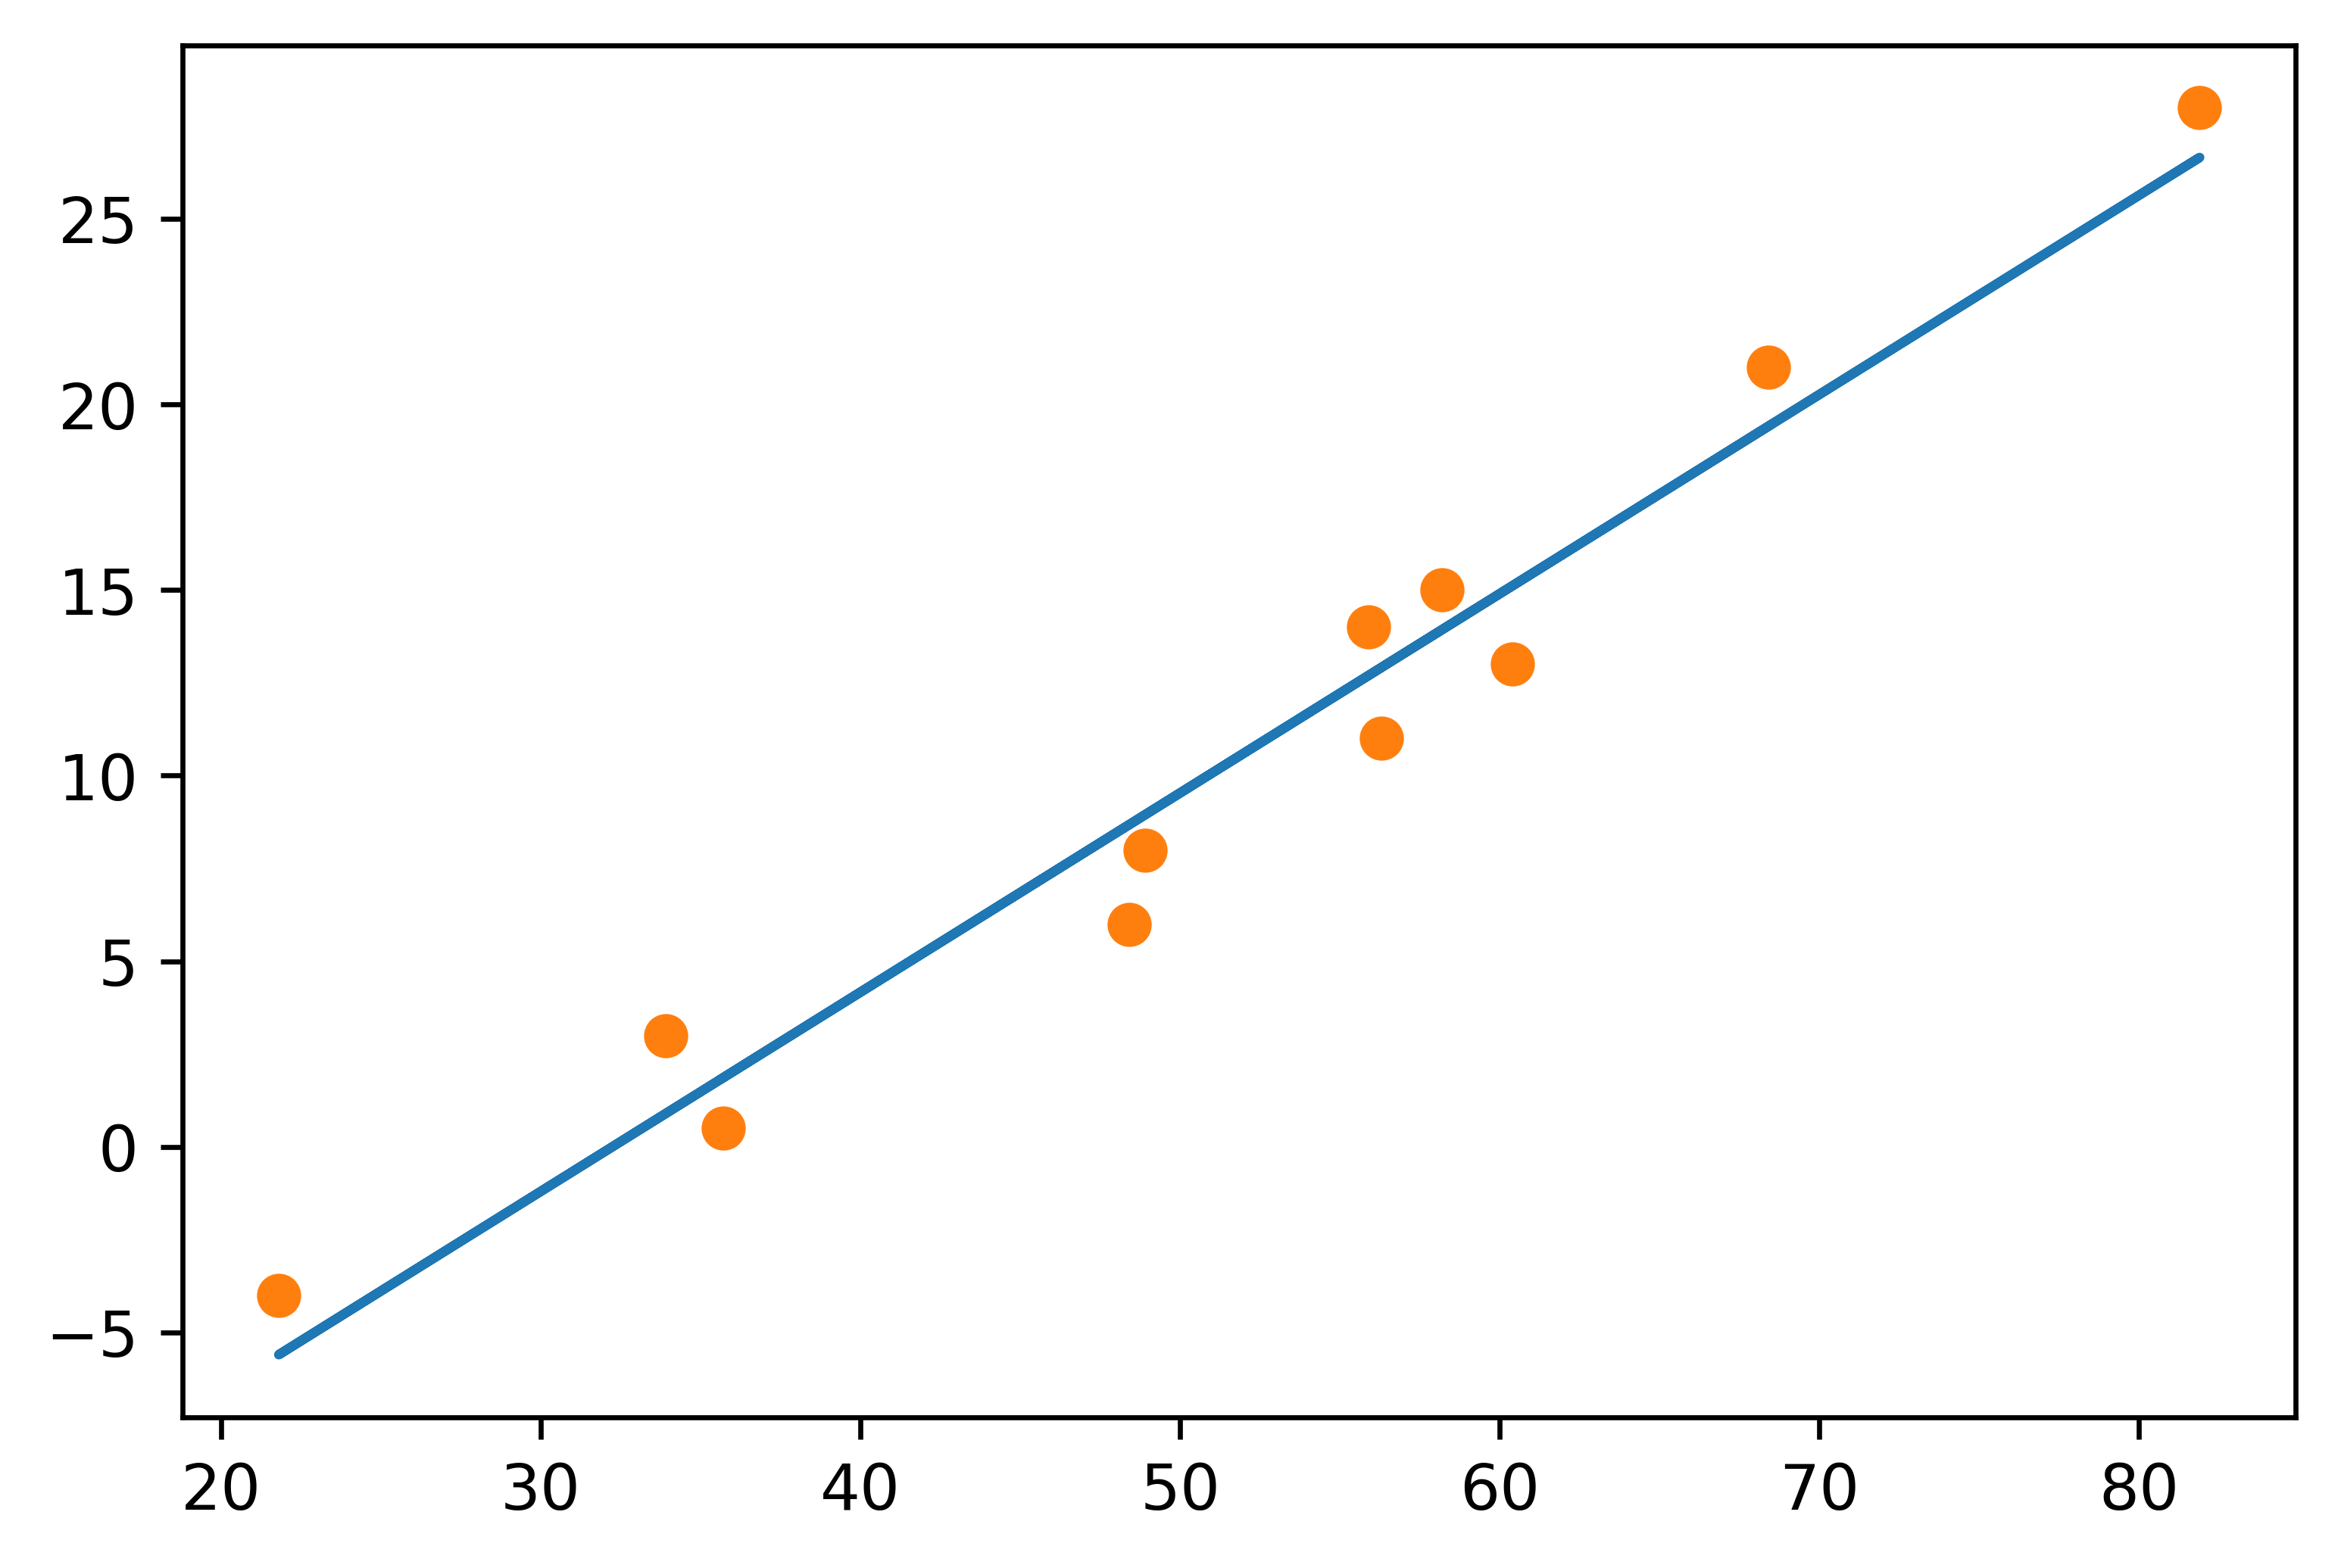

In [22]:
fig=plt.figure(dpi=600,facecolor='white')
plt.xlabel=("°Fahrenheit")
plt.ylabel=("°Celcius")
plt.plot(t_u.numpy(),t_p.detach().numpy())
plt.plot(t_u.numpy(),t_c.numpy(),'o')

### **5.1.8 Conclusion**
From this temperature conversion experiment, we were acknowledged with the forward pass and backward pass process. 

Forward pass is when the model is fed with the input data ('t_u') as well as its initial value of weights ('w'=1.0) and bias ('b'=0.0) then it is measured in regard to its error value by comparing the resulting outputs (predicted 't_c' --> 't_p') to the real 't_c' data.

Backward pass is when we want to optimize the parameters, weights ('w') and bias ('b'). The change in the error following a unit change in weights or the gradient of the error with respet to the parameters is computed using chain rule for the derivative of a composite function. The value of the weights is then updated in the direction that leads to a decrease in the error. The procedure is repeated until the error, evaluated on unseen data, falls below an acceptable level. So, we have done the computation of the gradient of a composition of functions - the model and the loss - with respect to their inner-most parameters - w and b - by propagating derivatives backwards using the chain rule, but manually, or explicitly write the formula in the code by creating the class 'grad_fn'.

The next sub-chapter, we will do this backpass using what is called Autograd.

